In [32]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors # Matplotlib and associated plotting modules
from sklearn.cluster import KMeans # import k-means from clustering stage
!conda install -c conda-forge beautifulsoup4 --yes
from bs4 import BeautifulSoup # website scraping libraries and packages in Python from BeautifulSoup 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim  # convert an address into latitude and longitude values
import folium # map rendering library
from bs4 import BeautifulSoup
import requests
import csv
from pandas.io.json import json_normalize # tranform JSON file into a pandas df
print('Libraries import complete')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries import complete


# Download New York City Neighbourhood Data

In [259]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Data downloaded!


In [260]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [261]:
neighborhoods.tail()

,Borough,Neighborhood,Latitude,Longitude
301,Manhattan,Hudson Yards,40.756658,-74.000111
302,Queens,Hammels,40.587338,-73.805530
303,Queens,Bayswater,40.611322,-73.765968
304,Queens,Queensbridge,40.756091,-73.945631
305,Staten Island,Fox Hills,40.617311,-74.081740


In [246]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


# Creating seperate dataframes for each Borough

In [123]:
bronx_data = neighborhoods[neighborhoods['Borough'] == 'Bronx'].reset_index(drop=True)
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
Staten_data = neighborhoods[neighborhoods['Borough'] == 'Staten Island'].reset_index(drop=True)

In [139]:
#testing one data frame randomly
Staten_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Staten Island,St. George,40.644982,-74.079353
1,Staten Island,New Brighton,40.640615,-74.087017
2,Staten Island,Stapleton,40.626928,-74.077902
3,Staten Island,Rosebank,40.615305,-74.069805
4,Staten Island,West Brighton,40.631879,-74.107182


# Visualization of NYC neighbourhoods

In [248]:
import folium
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

# Hospital Wards Distribution

In [262]:
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [263]:
LIMIT = 500 
radius = 5000 
CLIENT_ID = 'ZMHWBS0SR12Z3YDYVHJVTZPRK3U1ZP3I2TYQAJ5CU3JUHMB5'
CLIENT_SECRET = 'H3TT0XT3P5TIAFCV1Y2UUVLF42N44DICNKLUELK34H2TKLFR'
VERSION = '20181020'

In [386]:
#https://developer.foursquare.com/docs/resources/categories
#MedicalCenters =4bf58dd8d48988d104941735

#neighborhood medicalcenters
neighborhood_mc = getNearbyVenues(names=neighborhoods['Neighborhood'], latitudes=neighborhoods['Latitude'], longitudes=neighborhoods['Longitude'], radius=1000, categoryIds='4bf58dd8d48988d104941735')
neighborhood_mc.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Dentist's Office,40.899456,-73.845819,Dentist's Office
1,Wakefield,40.894705,-73.847201,LeBlanc Orthodontics,40.893917,-73.836206,Dentist's Office
2,Wakefield,40.894705,-73.847201,Regional Neurological Associates,40.901570,-73.854592,Doctor's Office
3,Wakefield,40.894705,-73.847201,Vanguard Health Center,40.892436,-73.853493,Doctor's Office
4,Wakefield,40.894705,-73.847201,"Rest Medical Care, P.C",40.890821,-73.850090,Doctor's Office


In [388]:
neighborhood_mc.count()

Neighborhood              10396
Neighborhood Latitude     10396
Neighborhood Longitude    10396
Venue                     10396
Venue Latitude            10396
Venue Longitude           10396
Venue Category            10396
dtype: int64

In [390]:
n_mc=neighborhood_mc

In [484]:
imp=['Emergency Room','Hospital','Hospital Ward','Medical Lab','Urgent Care Center']
n_mci=n_mc.loc[n_mc['Venue Category'].isin(imp)]
n_mci

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
25,Wakefield,40.894705,-73.847201,Moonlight Pediatrics,40.894582,-73.856429,Urgent Care Center
30,Co-op City,40.874294,-73.829939,Statcare Urgent & Walk-In Medical Care (Bronx ...,40.870168,-73.828404,Hospital
32,Co-op City,40.874294,-73.829939,CityMD Baychester Urgent Care - Bronx,40.866795,-73.827051,Hospital
57,Co-op City,40.874294,-73.829939,wellcare,40.874247,-73.837745,Hospital
76,Eastchester,40.887556,-73.827806,TransCare - Mt Vernon Base,40.895899,-73.825627,Emergency Room
...,...,...,...,...,...,...,...
10385,Fox Hills,40.617311,-74.081740,FDNY EMS 65J 10-89,40.623259,-74.083306,Emergency Room
10388,Fox Hills,40.617311,-74.081740,ice cooler,40.623820,-74.082300,Emergency Room
10391,Fox Hills,40.617311,-74.081740,Bayley Seton Hospital,40.622068,-74.074856,Hospital
10393,Fox Hills,40.617311,-74.081740,S.i. University Hospital Lab,40.618970,-74.068565,Hospital


In [467]:
n_mci

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
25,Wakefield,40.894705,-73.847201,Moonlight Pediatrics,40.894582,-73.856429,Urgent Care Center
30,Co-op City,40.874294,-73.829939,Statcare Urgent & Walk-In Medical Care (Bronx ...,40.870168,-73.828404,Hospital
32,Co-op City,40.874294,-73.829939,CityMD Baychester Urgent Care - Bronx,40.866795,-73.827051,Hospital
57,Co-op City,40.874294,-73.829939,wellcare,40.874247,-73.837745,Hospital
76,Eastchester,40.887556,-73.827806,TransCare - Mt Vernon Base,40.895899,-73.825627,Emergency Room
...,...,...,...,...,...,...,...
10385,Fox Hills,40.617311,-74.081740,FDNY EMS 65J 10-89,40.623259,-74.083306,Emergency Room
10388,Fox Hills,40.617311,-74.081740,ice cooler,40.623820,-74.082300,Emergency Room
10391,Fox Hills,40.617311,-74.081740,Bayley Seton Hospital,40.622068,-74.074856,Hospital
10393,Fox Hills,40.617311,-74.081740,S.i. University Hospital Lab,40.618970,-74.068565,Hospital


In [486]:
nyc_ward_stats=pd.merge(neighborhoods,
                   n_mci,
                   left_on='Neighborhood',
                   right_on='Neighborhood',
                   how='left')
# dropping neighbourhoods with no wards and reset index
nyc_ward_stats.dropna(axis=0, inplace=True)
nyc_ward_stats.reset_index(inplace=True)
#drop redundant latitude and longitude data
nyc_ward_stats.drop(['index','Latitude','Longitude'], axis=1, inplace=True)
nyc_ward_stats

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Wakefield,40.894705,-73.847201,Moonlight Pediatrics,40.894582,-73.856429,Urgent Care Center
1,Bronx,Co-op City,40.874294,-73.829939,Statcare Urgent & Walk-In Medical Care (Bronx ...,40.870168,-73.828404,Hospital
2,Bronx,Co-op City,40.874294,-73.829939,CityMD Baychester Urgent Care - Bronx,40.866795,-73.827051,Hospital
3,Bronx,Co-op City,40.874294,-73.829939,wellcare,40.874247,-73.837745,Hospital
4,Bronx,Eastchester,40.887556,-73.827806,TransCare - Mt Vernon Base,40.895899,-73.825627,Emergency Room
...,...,...,...,...,...,...,...,...
1334,Staten Island,Fox Hills,40.617311,-74.081740,FDNY EMS 65J 10-89,40.623259,-74.083306,Emergency Room
1335,Staten Island,Fox Hills,40.617311,-74.081740,ice cooler,40.623820,-74.082300,Emergency Room
1336,Staten Island,Fox Hills,40.617311,-74.081740,Bayley Seton Hospital,40.622068,-74.074856,Hospital
1337,Staten Island,Fox Hills,40.617311,-74.081740,S.i. University Hospital Lab,40.618970,-74.068565,Hospital


In [487]:
nyc_ward_grouped=nyc_ward_stats.groupby('Borough').count()
nyc_ward_grouped['Total_Hospital_Wards']=nyc_ward_grouped['Venue']
nyc_ward_grouped.drop(['Neighborhood','Neighborhood Longitude','Neighborhood Latitude','Venue','Venue Latitude','Venue Longitude','Venue Category'], axis=1, inplace=True)
nyc_ward_grouped

,Total_Hospital_Wards
Borough,
Bronx,229
Brooklyn,319
Manhattan,350
Queens,286
Staten Island,155


In [488]:
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['Neighborhood'], df['Venue'], df['Venue Category']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

In [489]:
map_newyork_in = folium.Map(location=[latitude, longitude], zoom_start=10)
addToMap(neighborhood_wards, 'red', map_newyork_in)

map_newyork_in

KeyboardInterrupt: 

In [490]:
nyc_covid_deaths= pd.read_csv('nyc_covid_deaths.csv')
nyc_population= pd.read_csv('nycpop.csv')

In [491]:
nyc_stats=pd.merge(nyc_infections,
                   nyc_population,
                   left_on='Borough',
                   right_on='Borough',
                   how='left')
nyc_stats.replace(to_replace='The Bronx',value='Bronx',inplace=True)

In [492]:
nyc_stats

,Borough,"Rate per 100,000 people",Count,population,density,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Bronx,2115.28,31130,1432132.0,13231.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Brooklyn,1352.06,36699,2582830.0,14649.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Manhattan,927.00,17495,1628701.0,27826.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Queens,1700.58,42637,2278906.0,8354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Staten Island,2075.01,10405,476179.0,3132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Citywide,NaN,138435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [493]:
nyc_stats=nyc_stats[['Borough','Count','population']]
#Drop Emply rows
nyc_stats.dropna(axis=0, inplace=True)
nyc_stats
nyc_ward_grouped



/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Total_Hospital_Wards
Borough,
Bronx,229
Brooklyn,319
Manhattan,350
Queens,286
Staten Island,155


In [494]:
nyc_stats=pd.merge(nyc_stats,
                   nyc_ward_grouped,
                   left_on='Borough',
                   right_on='Borough',
                   how='left')


In [476]:
nyc_stats

,Borough,Count,population,Total_Hospital_Wards
0,Bronx,31130,1432132.0,229
1,Brooklyn,36699,2582830.0,319
2,Manhattan,17495,1628701.0,350
3,Queens,42637,2278906.0,286
4,Staten Island,10405,476179.0,155


In [495]:
nyc_stats.rename(columns={'Count':'Total_Deaths'},inplace=True)
nyc_stats['Deaths per 1000']=(nyc_stats['Total_Deaths']/nyc_stats['population'])*1000

#['population'].astype('int64')

In [496]:
nyc_stats_d=nyc_stats.sort_values('Deaths per 1000',ascending=False)
nyc_stats_d

,Borough,Total_Deaths,population,Total_Hospital_Wards,Deaths per 1000
4,Staten Island,10405,476179.0,155,21.851027
0,Bronx,31130,1432132.0,229,21.736823
3,Queens,42637,2278906.0,286,18.709416
1,Brooklyn,36699,2582830.0,319,14.208833
2,Manhattan,17495,1628701.0,350,10.741689


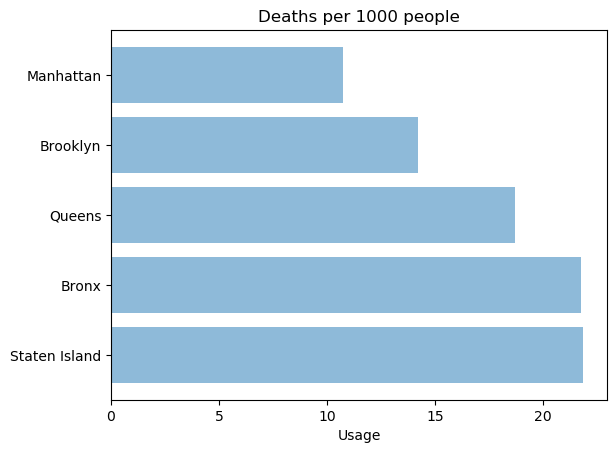

In [497]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = nyc_stats_d['Borough']
y_pos = np.arange(len(objects))

plt.barh(y_pos, nyc_stats_d['Deaths per 1000'], align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Usage')
plt.title('Deaths per 1000 people')

plt.show()

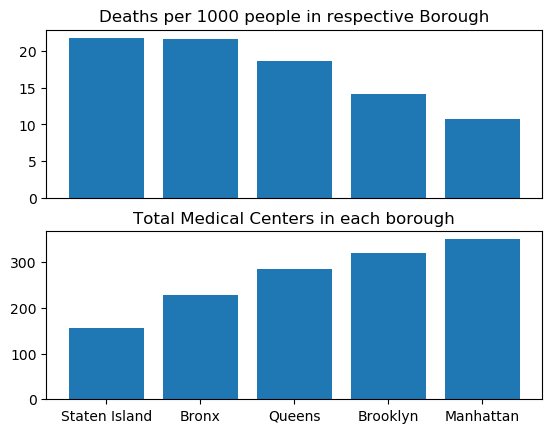

In [498]:
x = nyc_stats_d['Borough']
#The below code will create two plots. The parameters that .subplot take are (row, column, no. of plots).
plt.subplot(2,1,1)
#This will create the bar graph for poulation
pop = plt.bar(x, nyc_stats_d['Deaths per 1000'])

plt.xticks([],[])
plt.title('Deaths per 1000 people in respective Borough')
#The below code will create the second plot.
plt.subplot(2,1,2)
#This will create the bar graph for gdp i.e gdppercapita divided by population.
gdp =plt.bar(x, nyc_stats_d['Total_Hospital_Wards'])

plt.title('Total Medical Centers in each borough')
#plt.xticks(x, datasort['country'], rotation='vertical')
plt.show()

In [499]:
n_mci

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
25,Wakefield,40.894705,-73.847201,Moonlight Pediatrics,40.894582,-73.856429,Urgent Care Center
30,Co-op City,40.874294,-73.829939,Statcare Urgent & Walk-In Medical Care (Bronx ...,40.870168,-73.828404,Hospital
32,Co-op City,40.874294,-73.829939,CityMD Baychester Urgent Care - Bronx,40.866795,-73.827051,Hospital
57,Co-op City,40.874294,-73.829939,wellcare,40.874247,-73.837745,Hospital
76,Eastchester,40.887556,-73.827806,TransCare - Mt Vernon Base,40.895899,-73.825627,Emergency Room
...,...,...,...,...,...,...,...
10385,Fox Hills,40.617311,-74.081740,FDNY EMS 65J 10-89,40.623259,-74.083306,Emergency Room
10388,Fox Hills,40.617311,-74.081740,ice cooler,40.623820,-74.082300,Emergency Room
10391,Fox Hills,40.617311,-74.081740,Bayley Seton Hospital,40.622068,-74.074856,Hospital
10393,Fox Hills,40.617311,-74.081740,S.i. University Hospital Lab,40.618970,-74.068565,Hospital


# Trying to find isolated hospitals

In [502]:
nyc_grouped = n_mci.groupby('Neighborhood').count()
nyc_grouped
#print('There are {} uniques categories.'.format(len(newyork_venues_sushi['Venue Category'].unique())))

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,2,2,2,2,2,2
Arden Heights,1,1,1,1,1,1
Arlington,2,2,2,2,2,2
Arverne,1,1,1,1,1,1
Astoria,9,9,9,9,9,9
...,...,...,...,...,...,...
Wingate,11,11,11,11,11,11
Woodhaven,2,2,2,2,2,2
Woodlawn,4,4,4,4,4,4


In [505]:
# one hot encoding
nyc_onehot = pd.get_dummies(n_mci[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = n_mci['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

,Neighborhood,Emergency Room,Hospital,Hospital Ward,Medical Lab,Urgent Care Center
25,Wakefield,0,0,0,0,1
30,Co-op City,0,1,0,0,0
32,Co-op City,0,1,0,0,0
57,Co-op City,0,1,0,0,0
76,Eastchester,1,0,0,0,0


In [510]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped

,Neighborhood,Emergency Room,Hospital,Hospital Ward,Medical Lab,Urgent Care Center
0,Allerton,0.500000,0.000000,0.0,0.500000,0.000000
1,Arden Heights,0.000000,0.000000,0.0,0.000000,1.000000
2,Arlington,0.000000,0.500000,0.0,0.500000,0.000000
3,Arverne,0.000000,1.000000,0.0,0.000000,0.000000
4,Astoria,0.111111,0.444444,0.0,0.333333,0.111111
...,...,...,...,...,...,...
255,Wingate,0.181818,0.727273,0.0,0.090909,0.000000
256,Woodhaven,0.500000,0.500000,0.0,0.000000,0.000000
257,Woodlawn,0.500000,0.250000,0.0,0.000000,0.250000
258,Woodside,0.000000,0.666667,0.0,0.000000,0.333333


In [511]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [530]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Medical Lab,Emergency Room,Urgent Care Center,Hospital Ward,Hospital
1,Arden Heights,Urgent Care Center,Medical Lab,Hospital Ward,Hospital,Emergency Room
2,Arlington,Medical Lab,Hospital,Urgent Care Center,Hospital Ward,Emergency Room
3,Arverne,Hospital,Urgent Care Center,Medical Lab,Hospital Ward,Emergency Room
4,Astoria,Hospital,Medical Lab,Urgent Care Center,Emergency Room,Hospital Ward


In [531]:
# set number of clusters
kclusters = 5

nyc_grouped_clustering =nyc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 3, 2, 0, 2, 4, 2, 0, 0, 0], dtype=int32)

In [532]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = neighborhoods
nyc_merged = nyc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

nyc_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,3.0,Urgent Care Center,Medical Lab,Hospital Ward,Hospital,Emergency Room
1,Bronx,Co-op City,40.874294,-73.829939,0.0,Hospital,Urgent Care Center,Medical Lab,Hospital Ward,Emergency Room
2,Bronx,Eastchester,40.887556,-73.827806,1.0,Emergency Room,Urgent Care Center,Medical Lab,Hospital Ward,Hospital
3,Bronx,Fieldston,40.895437,-73.905643,3.0,Urgent Care Center,Medical Lab,Hospital,Hospital Ward,Emergency Room
4,Bronx,Riverdale,40.890834,-73.912585,2.0,Medical Lab,Hospital,Urgent Care Center,Hospital Ward,Emergency Room


In [560]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [546]:
nyc_merged.dropna(axis=0, inplace=True)


In [558]:
nyc_merged['Cluster Labels']=nyc_merged['Cluster Labels'].astype('int')

# Verifying cluster data

In [561]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Co-op City,Hospital,Urgent Care Center,Medical Lab,Hospital Ward,Emergency Room
6,Marble Hill,Hospital,Emergency Room,Medical Lab,Urgent Care Center,Hospital Ward
8,Norwood,Hospital,Emergency Room,Hospital Ward,Urgent Care Center,Medical Lab
13,Bedford Park,Hospital,Urgent Care Center,Emergency Room,Medical Lab,Hospital Ward
15,Morris Heights,Hospital,Emergency Room,Medical Lab,Urgent Care Center,Hospital Ward
...,...,...,...,...,...,...
296,Madison,Hospital,Medical Lab,Urgent Care Center,Hospital Ward,Emergency Room
299,Kingsbridge Heights,Hospital,Emergency Room,Medical Lab,Urgent Care Center,Hospital Ward
300,Erasmus,Hospital,Medical Lab,Emergency Room,Urgent Care Center,Hospital Ward
304,Queensbridge,Hospital,Hospital Ward,Emergency Room,Urgent Care Center,Medical Lab


In [562]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Eastchester,Emergency Room,Urgent Care Center,Medical Lab,Hospital Ward,Hospital
7,Woodlawn,Emergency Room,Urgent Care Center,Hospital,Medical Lab,Hospital Ward
14,University Heights,Hospital,Emergency Room,Urgent Care Center,Medical Lab,Hospital Ward
26,Soundview,Emergency Room,Urgent Care Center,Medical Lab,Hospital Ward,Hospital
40,Castle Hill,Emergency Room,Hospital,Urgent Care Center,Medical Lab,Hospital Ward
42,Pelham Gardens,Emergency Room,Hospital,Urgent Care Center,Medical Lab,Hospital Ward
44,Unionport,Emergency Room,Urgent Care Center,Medical Lab,Hospital Ward,Hospital
56,East Flatbush,Emergency Room,Medical Lab,Hospital Ward,Urgent Care Center,Hospital
60,Brownsville,Hospital,Emergency Room,Urgent Care Center,Medical Lab,Hospital Ward
63,Bedford Stuyvesant,Emergency Room,Hospital,Urgent Care Center,Medical Lab,Hospital Ward


In [565]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Riverdale,Medical Lab,Hospital,Urgent Care Center,Hospital Ward,Emergency Room
5,Kingsbridge,Hospital,Medical Lab,Urgent Care Center,Hospital Ward,Emergency Room
11,Pelham Parkway,Hospital,Emergency Room,Urgent Care Center,Medical Lab,Hospital Ward
18,West Farms,Medical Lab,Hospital Ward,Hospital,Urgent Care Center,Emergency Room
21,Mott Haven,Medical Lab,Hospital,Urgent Care Center,Hospital Ward,Emergency Room
...,...,...,...,...,...,...
273,Turtle Bay,Hospital,Urgent Care Center,Medical Lab,Hospital Ward,Emergency Room
278,Blissville,Medical Lab,Hospital,Urgent Care Center,Hospital Ward,Emergency Room
287,Egbertville,Medical Lab,Hospital,Urgent Care Center,Hospital Ward,Emergency Room
289,Homecrest,Medical Lab,Hospital,Urgent Care Center,Hospital Ward,Emergency Room


In [566]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Wakefield,Urgent Care Center,Medical Lab,Hospital Ward,Hospital,Emergency Room
3,Fieldston,Urgent Care Center,Medical Lab,Hospital,Hospital Ward,Emergency Room
10,Baychester,Urgent Care Center,Hospital,Medical Lab,Hospital Ward,Emergency Room
32,Van Nest,Urgent Care Center,Hospital,Medical Lab,Hospital Ward,Emergency Room
36,North Riverdale,Urgent Care Center,Medical Lab,Hospital Ward,Hospital,Emergency Room
38,Schuylerville,Urgent Care Center,Medical Lab,Hospital,Hospital Ward,Emergency Room
47,Bensonhurst,Urgent Care Center,Hospital,Medical Lab,Hospital Ward,Emergency Room
50,Gravesend,Urgent Care Center,Hospital,Medical Lab,Hospital Ward,Emergency Room
62,Bushwick,Urgent Care Center,Emergency Room,Hospital,Medical Lab,Hospital Ward
66,Carroll Gardens,Urgent Care Center,Hospital,Emergency Room,Medical Lab,Hospital Ward


In [ ]:
nyc_merged.groupby()

In [568]:
nyc_merged_grouped= nyc_merged.groupby('Cluster Labels').count()
nyc_merged_grouped

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Cluster Labels,,,,,,,,,
0,111,111,111,111,111,111,111,111,111
1,42,42,42,42,42,42,42,42,42
2,63,63,63,63,63,63,63,63,63
3,28,28,28,28,28,28,28,28,28
4,20,20,20,20,20,20,20,20,20


In [ ]:
nyc_stats=pd.merge(nyc_stats,
                   nyc_ward_grouped,
                   left_on='Borough',
                   right_on='Borough',
                   how='left')
